In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
from IPython.display import Audio, display

In [2]:
fs_orig, signal_orig = wavfile.read('input.wav')

In [3]:
# Stereo to mono if needed
if len(signal_orig.shape) > 1:
    signal_orig = signal_orig[:, 0]

In [4]:
# Normalize
signal_orig = signal_orig / np.max(np.abs(signal_orig))

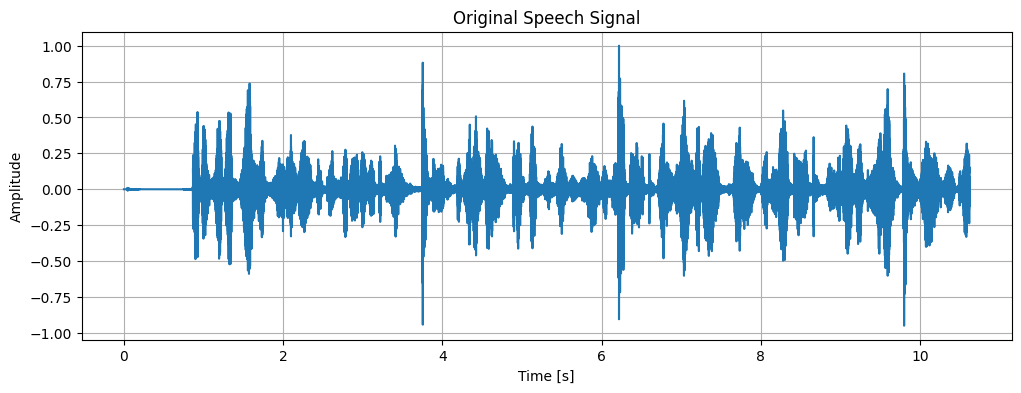

In [5]:
t_orig = np.arange(len(signal_orig)) / fs_orig
plt.figure(figsize=(12, 4))
plt.plot(t_orig, signal_orig)
plt.title("Original Speech Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [6]:
print("Original Audio:")
display(Audio(signal_orig, rate=fs_orig))


Original Audio:


In [8]:
sampling_rates = [8000, 16000, 44100]
sampled_signals = {}

for fs_new in sampling_rates:
    t_new = np.arange(0, len(signal_orig)/fs_orig, 1/fs_new)
    sampled_signal = np.interp(t_new, t_orig, signal_orig)
    sampled_signals[fs_new] = (t_new, sampled_signal)

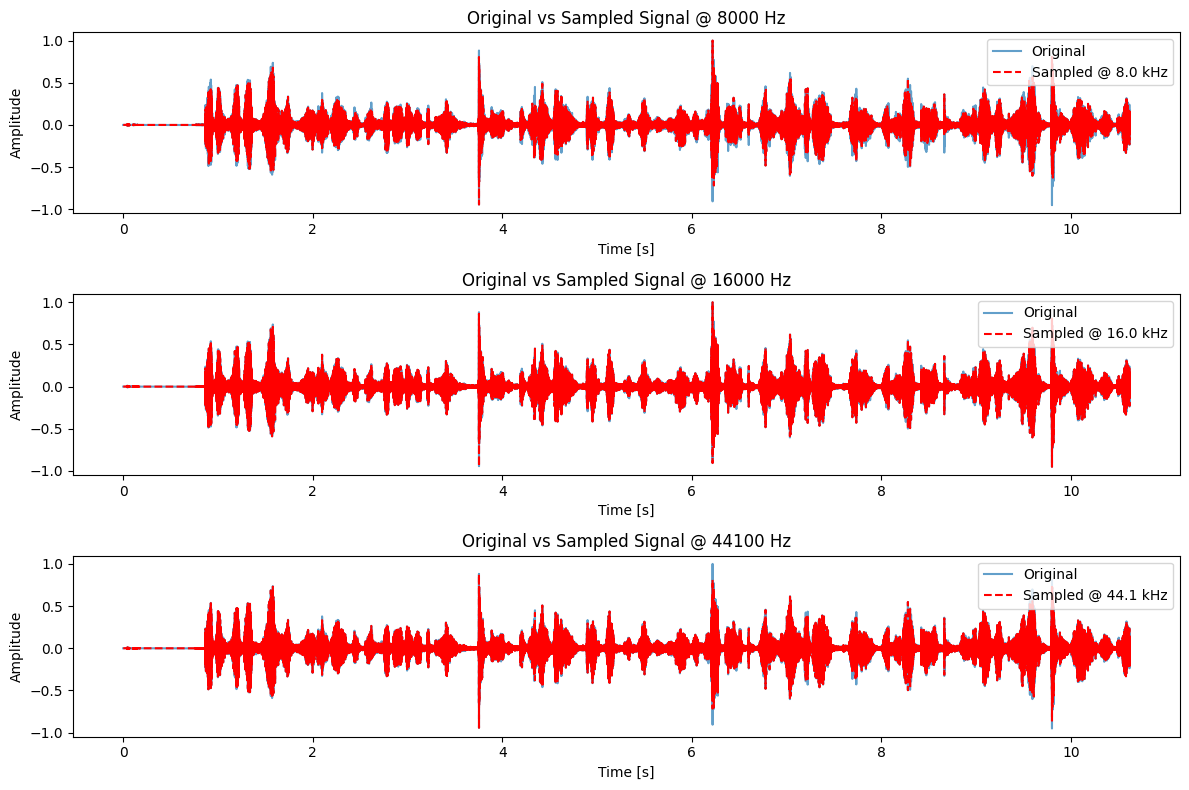

In [9]:
plt.figure(figsize=(12, 8))

for i, (fs_new, (t_new, sampled_signal)) in enumerate(sampled_signals.items(), 1):
    plt.subplot(3, 1, i)
    plt.plot(t_orig, signal_orig, label="Original", alpha=0.7)
    plt.plot(t_new, sampled_signal, 'r--', label=f"Sampled @ {fs_new/1000:.1f} kHz")
    plt.title(f"Original vs Sampled Signal @ {fs_new} Hz")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

In [10]:
reconstructed_signals = {}

for fs_new in sampling_rates:
    t_sampled, sampled_signal = sampled_signals[fs_new]

    # Zero-order hold
    f_zero = interp1d(t_sampled, sampled_signal, kind='nearest', fill_value="extrapolate")
    signal_recon_zero = f_zero(t_orig)

    # Linear interpolation
    f_linear = interp1d(t_sampled, sampled_signal, kind='linear', fill_value="extrapolate")
    signal_recon_linear = f_linear(t_orig)

    reconstructed_signals[fs_new] = {
        'zero': signal_recon_zero,
        'linear': signal_recon_linear
    }

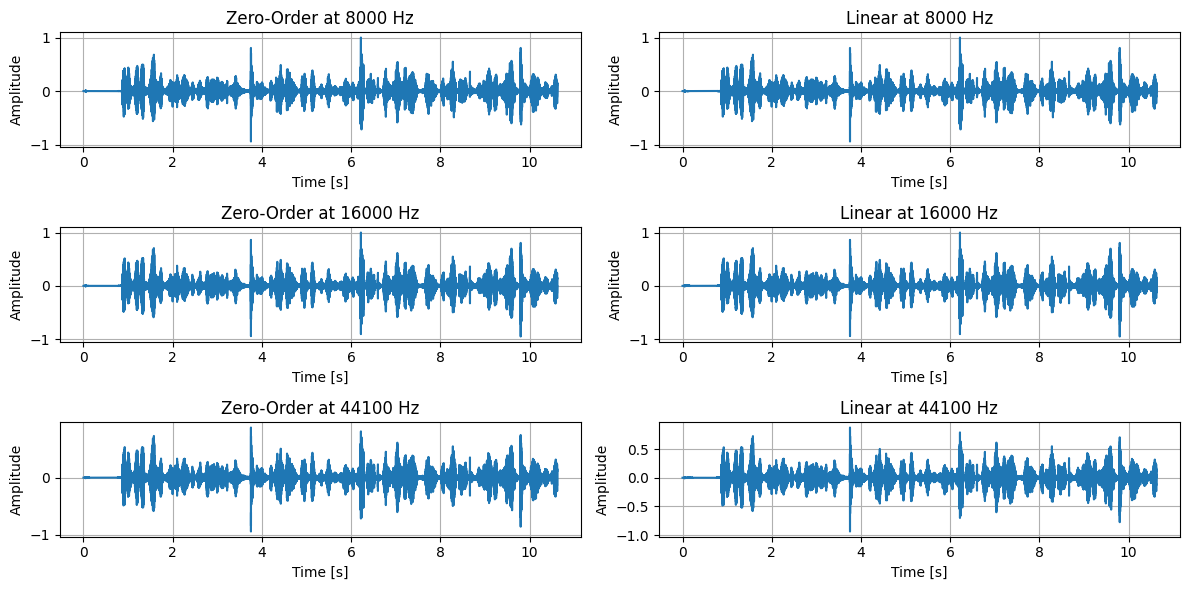

In [11]:
plt.figure(figsize=(12, 6))
for i, fs_new in enumerate(sampling_rates):
    plt.subplot(len(sampling_rates), 2, 2*i+1)
    plt.plot(t_orig, reconstructed_signals[fs_new]['zero'])
    plt.title(f"Zero-Order at {fs_new} Hz")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.grid(True)

    plt.subplot(len(sampling_rates), 2, 2*i+2)
    plt.plot(t_orig, reconstructed_signals[fs_new]['linear'])
    plt.title(f"Linear at {fs_new} Hz")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
print("Mean Squared Error (MSE):")
for fs_new in sampling_rates:
    mse_zero = mean_squared_error(signal_orig, reconstructed_signals[fs_new]['zero'])
    mse_linear = mean_squared_error(signal_orig, reconstructed_signals[fs_new]['linear'])
    print(f"Sampling Rate: {fs_new} Hz | Zero-Order MSE: {mse_zero:.6f} | Linear MSE: {mse_linear:.6f}")

Mean Squared Error (MSE):
Sampling Rate: 8000 Hz | Zero-Order MSE: 0.003236 | Linear MSE: 0.002848
Sampling Rate: 16000 Hz | Zero-Order MSE: 0.000736 | Linear MSE: 0.000371
Sampling Rate: 44100 Hz | Zero-Order MSE: 0.000130 | Linear MSE: 0.000044
